## Introduction
We can try to infer the the distribution of samples from a normal distribution, given the mean. This is conditional density estimation.

In [1]:
from jax import random
import jax.numpy as jnp
from jaxflows.bijections.coupling import CouplingStack
from jaxflows.bijections.rational_quadratic_spline import RationalQuadraticSpline
from jaxflows.flow import Flow
from jaxflows.train_utils import train_flow
from jax.config import config
config.update("jax_debug_nans", True)

In [2]:
key, x_key, cond_key = random.split(random.PRNGKey(0), 3)
cond = random.uniform(cond_key, (10000, 1), minval=-1, maxval=1)
x = random.normal(x_key, (10000, 2))*0.5 + cond

In [3]:
from jaxflows.bijections.affine import Affine

In [4]:
key = random.PRNGKey(1)
bijection = CouplingStack(
    key=key,
    bijection=RationalQuadraticSpline(K=8, B=4),
    D=x.shape[1],
    num_layers=8,
    condition_dim=cond.shape[1])

flow = Flow(bijection, target_dim = x.shape[1])
key, subkey = random.split(key)


In [5]:
flow, losses = train_flow(flow, key, x, condition=cond, max_epochs=50)

100%|██████████| 50/50 [02:12<00:00,  2.65s/it, train=1.44, val=1.46]


## Sampling
We can now sample, for example conditioning on a mean value of 0.5.

In [9]:
n = 1000
cond_for_sample = jnp.full((n, 1), 0.5)
sample = flow.sample(random.PRNGKey(0), n, condition=cond_for_sample)

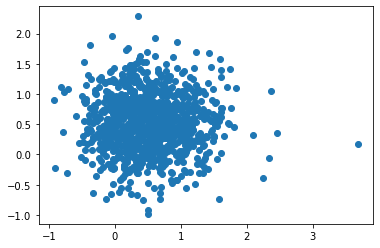

In [10]:
import matplotlib.pyplot as plt
sample = flow.sample(random.PRNGKey(0), n, condition=cond_for_sample)
plt.scatter(x = sample[:, 0], y = sample[:, 1])